In [1]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import os
import pandas as pd
import re
import numpy as np
import base64
import numpy as np
import cv2
import undetected_chromedriver as uc
import argparse
from urllib.parse import urlparse
import io
from PIL import Image
import time
import os
import base64
import numpy as np
import cv2
import undetected_chromedriver as uc
import argparse
from urllib.parse import urlparse
import io
from PIL import Image
import time
import os

In [30]:
# Funciones

def download_image_to_numpy(driver ,url, wait_time=10):
    """
    Downloads an image from a URL that blocks normal requests (like Ripley's CDN)
    and returns it as a numpy array using undetected-chromedriver to bypass protection.
    
    Args:
        url: URL of the image to download
        wait_time: Time to wait for Cloudflare challenges to resolve (seconds)
        
    Returns:
        numpy array of the image
    """

    
    try:

        # Now navigate to the actual image URL
        print(f"Now navigating to the image URL...")
        driver.get(url)
        
        # Additional wait for any challenges
        print(f"Waiting {wait_time} seconds for any Cloudflare challenges...")
        time.sleep(wait_time)
        
        # Check if we're on a Cloudflare challenge page
        page_source = driver.page_source
        if "Just a moment..." in page_source or "Checking your browser" in page_source:
            print("Detected Cloudflare challenge page, waiting for it to resolve...")
            # Wait longer for the challenge to resolve
            time.sleep(wait_time * 2)
        
        # If it's a direct image, the content should be binary, not HTML
        content_type = driver.execute_script("return document.contentType")
        print(f"Content type: {content_type}")
        
        if content_type and "image" in content_type.lower():
            print("Direct image detected, downloading...")
            # For direct image URLs that load in the browser
            get_base64 = """
            const callback = arguments[0];
            let canvas = document.createElement('canvas');
            let img = document.querySelector('img');
            if (!img) {
                // If no img tag (direct image), convert the body to base64
                let reader = new FileReader();
                reader.onloadend = function() {
                    callback(reader.result.split(',')[1]);
                }
                fetch(window.location.href)
                    .then(response => response.blob())
                    .then(blob => reader.readAsDataURL(blob));
            } else {
                // If there's an img tag
                canvas.width = img.naturalWidth;
                canvas.height = img.naturalHeight;
                canvas.getContext('2d').drawImage(img, 0, 0);
                callback(canvas.toDataURL('image/png').split(',')[1]);
            }
            """
        else:
            # For URLs that require fetch
            print("Using fetch to get image content...")
            get_base64 = """
            const url = arguments[0];
            const callback = arguments[1];
            fetch(url, { 
                credentials: 'include',
                headers: {
                    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
                }
            })
            .then(resp => {
                if (!resp.ok) {
                    throw new Error('Network response was not ok: ' + resp.status);
                }
                return resp.blob();
            })
            .then(blob => {
                if (blob.type.startsWith('text/html')) {
                    throw new Error('Received HTML instead of an image');
                }
                const reader = new FileReader();
                reader.onloadend = () => callback(reader.result.split(',')[1]);
                reader.readAsDataURL(blob);
            })
            .catch(error => {
                console.error('Error:', error);
                callback(null);
            });
            """
        
        # Execute the script and get the base64 image data
        base64_str = driver.execute_async_script(get_base64, url) if "image" not in content_type.lower() else driver.execute_async_script(get_base64)
        
        if not base64_str:
            # If we couldn't get the image, take a screenshot as fallback
            print("Failed to get image through JavaScript, trying screenshot of the page...")
            if "image" in content_type.lower():
                screenshot = driver.get_screenshot_as_base64()
                if screenshot:
                    base64_str = screenshot
                    print("Retrieved image via screenshot")
                else:
                    raise RuntimeError("Failed to take screenshot")
            else:
                raise RuntimeError("Failed to download image. Received non-image content.")
        
        # Decode the Base64 to bytes
        img_bytes = base64.b64decode(base64_str)
        
        # Check if we got HTML instead of an image
        if img_bytes[:20].find(b'<!DOCTYPE') != -1 or img_bytes[:20].find(b'<html') != -1:
            # Save the HTML for debugging
            with open("error_page.html", "wb") as f:
                f.write(img_bytes)
            raise RuntimeError("Received HTML instead of an image. Saved to error_page.html for debugging.")
        
        # Intenta primero con OpenCV
        buf = np.frombuffer(img_bytes, dtype=np.uint8)
        img = cv2.imdecode(buf, cv2.IMREAD_UNCHANGED)
        
        # Si OpenCV falla, intenta con PIL/Pillow
        if img is None:
            print("OpenCV failed to decode the image, trying with PIL...")
            pil_img = Image.open(io.BytesIO(img_bytes))
            img = np.array(pil_img)
            
            # Convertir RGBA a BGR si es necesario para OpenCV
            if len(img.shape) == 3 and img.shape[2] == 4:
                # Convertir RGBA a RGB
                rgb_img = pil_img.convert('RGB')
                img = np.array(rgb_img)
                # Convertir RGB a BGR para OpenCV
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            elif len(img.shape) == 3 and img.shape[2] == 3:
                # Convertir RGB a BGR para OpenCV
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                
        if img is None:
            raise RuntimeError("Failed to decode the image with both OpenCV and PIL.")
            
        return img
        
    except Exception as e:
        return None
    
    #finally:
        # Always quit the driver to free resources
    #    driver.quit()

In [25]:
import undetected_chromedriver as uc


driver = uc.Chrome(headless=False)  

driver.get("https://simple.ripley.com.pe/moda/especiales/ver-todo-polos?source=search&term=polos&s=mdco")

driver.maximize_window()



In [4]:
def scrap_ripley(driver):
    
    

    descripciones = []
    precios_regular = []
    precios_oferta = []
    imagenes = []
    for i in range(1,50):
        try:
            descripcion = driver.find_element(By.XPATH, f'/html/body/div[7]/div[2]/div/div[2]/section/div/div/div[{i}]/div/a/div[3]/div[3]').text ## Descripcion
            descripciones.append(descripcion)
            
        except:
            descripciones.append("")
        try:
            precio_regular = driver.find_element(By.XPATH, f"/html/body/div[7]/div[2]/div/div[2]/section/div/div/div[{i}]/div/a/div[3]/div[4]/div/ul/li[1]").text # Precio regular
            precios_regular.append(precio_regular)
        except:
            precios_regular.append(" ")
            
            
        try:
            precio_oferta = driver.find_element(By.XPATH,f"/html/body/div[7]/div[2]/div/div[2]/section/div/div/div[{i}]/div/a/div[3]/div[4]/div/ul/li[2]").text # Precio oferta
            precios_oferta.append(precio_oferta)
        except:
            precios_oferta.append(" ")
            
            
            
        try:
            imagen = driver.find_element(By.XPATH,f"/html/body/div[7]/div[2]/div/div[2]/section/div/div/div[{i}]/div/a/div[2]/div[2]/div[1]/img").get_attribute("src") # Imagen
            imagenes.append(imagen)
                
        except:
            try:
                imagen = driver.find_element(By.XPATH,f"/html/body/div[7]/div[2]/div/div[2]/section/div/div/div[{i}]/div/a/div[2]/div[2]/div[4]/img").get_attribute("src") # Imagen                                           
                imagenes.append(imagen)
            except:
                try:
                    imagen = driver.find_element(By.XPATH,f"/html/body/div[7]/div[2]/div/div[2]/section/div/div/div[{i}]/div/a/div[2]/div[2]/div[3]/img").get_attribute("src") # Imagen
                    imagenes.append(imagen)
                except:
                    try:
                        imagen = driver.find_element(By.XPATH,f"/html/body/div[7]/div[2]/div/div[2]/section/div/div/div[{i}]/div/a/div[2]/div[2]/div[2]/img").get_attribute("src") # Imagen
                        imagenes.append(imagen)
                            
                    except:
                        imagenes.append("")
        
        
        inicio = 0
        fin = 500
        ActionChains(driver)\
        .scroll_by_amount(inicio, fin)\
        .perform()
        inicio = fin
        fin = fin + 1000

  
    return descripciones, precios_regular, precios_oferta, imagenes



In [5]:

descripciones, precios_regular, precios_oferta, imagenes = scrap_ripley(driver)

In [147]:
final_descripciones = []
final_precios_regular = []
final_precios_oferta = []
final_imagenes = []

#final_descripciones.extend(descripciones)
#final_precios_regular.extend(precios_regular)
#final_precios_oferta.extend(precios_oferta)
#final_imagenes.extend(imagenes)

In [153]:
page_number = 5
#driver.get(f"https://simple.ripley.com.pe/moda/especiales/ver-todo-polos?source=search&term=polos&s=mdco&page={page_number}")
driver.get(f"https://simple.ripley.com.pe/moda/especiales/pantalones?source=search&term=pantalones&s=mdco&page={page_number}")
driver.implicitly_wait(5)
descripciones, precios_regular, precios_oferta, imagenes = scrap_ripley(driver)
final_descripciones.extend(descripciones)
final_precios_regular.extend(precios_regular)
final_precios_oferta.extend(precios_oferta)
final_imagenes.extend(imagenes)

In [154]:
print(len(final_precios_oferta))
print(len(final_precios_regular))
print(len(final_descripciones))


final_descripciones


245
245
245


['PANTALÓN MUJER INDEX CARGO-E',
 'PANTALÓN MUJER MARQUIS DALZA',
 'PANTALÓN MOM MUJER MACHINE BLANCO JEANE',
 'JEAN HOMBRE INDEX NEW SMOKE',
 'PANTALÓN HOMBRE INDEX CALI',
 'PANTALÓN SLIM MUJER DOCKERS AZUL MINNA JEANCUT',
 '',
 'PANTALÓN ALGODÓN HOMBRE CLOUDBREAK JOGGER',
 'PANTALÓN HOMBRE NAVIGATA CHAD',
 'PANTALÓN LINO WIDELEG MUJER PIONIER TANNIAH',
 'PANTALÓN HOMBRE KANSAS K02440 LOOSE FIT CARGO',
 'PANTALÓN SKINNY MUJER SODA BLUES GIGY',
 'PANTALÓN CASUAL SLIM HOMBRE DOCKERS GO TAPERED FIT',
 'PANTALÓN HOMBRE KENNETH STEVENS BELT',
 'PANTALÓN JOGGER HOMBRE ROBERT LEWIS BRADY',
 'PANTALÓN ALGODÓN JOGGER CARGO HOMBRE BARBADOS CHINO',
 'PANTALÓN REGULAR MUJER CACHAREL ELCHI',
 'PANTALÓN ALGODÓN PALAZZO MUJER SODA BLUES GINER',
 'PANTALÓN SLIM HOMBRE DOCKERS BEIGE ALPHA CHINO',
 'PANTALÓN RECTO HOMBRE DOCKERS GRIS JEAN CUT',
 'PANTALÓN RECTO HOMBRE DOCKERS BLANCO JEAN CUT',
 'PANTALÓN ALGODÓN MUJER METAL JEANS PARACHUTE IBIZA',
 'PANTALÓN SLIM MUJER DOCKERS AZUL MINNA JEANCUT',
 'PA

In [156]:
data = pd.DataFrame({"descripcion": final_descripciones, "precio_regular": final_precios_regular, "precio_oferta": final_precios_oferta, "imagen": final_imagenes})

data_polos = pd.read_csv("data.csv")
data_total = pd.concat([data_polos, data])
data_total
data_total.to_csv("data.csv", index=False)

In [31]:
data_sample = data.sample(1)
data["img_array"] = data.apply(lambda row: download_image_to_numpy(driver, row["imagen"]), axis=1)

Now navigating to the image URL...
Waiting 10 seconds for any Cloudflare challenges...
Content type: image/webp
Direct image detected, downloading...
Now navigating to the image URL...
Waiting 10 seconds for any Cloudflare challenges...
Content type: image/webp
Direct image detected, downloading...
Now navigating to the image URL...
Waiting 10 seconds for any Cloudflare challenges...
Content type: image/webp
Direct image detected, downloading...
Now navigating to the image URL...
Waiting 10 seconds for any Cloudflare challenges...
Content type: image/webp
Direct image detected, downloading...
Now navigating to the image URL...
Waiting 10 seconds for any Cloudflare challenges...
Content type: image/webp
Direct image detected, downloading...
Now navigating to the image URL...
Waiting 10 seconds for any Cloudflare challenges...
Content type: image/webp
Direct image detected, downloading...
Now navigating to the image URL...
Now navigating to the image URL...
Waiting 10 seconds for any Clo

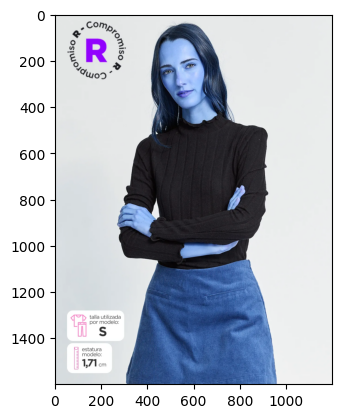

In [39]:
import matplotlib.pyplot as plt
plt.imshow(data["img_array"].loc[0])

In [40]:
data.to_csv("data_w_img.csv", index=False)

In [43]:
data = data[data["img_array"].notna()]

In [44]:
from PIL import Image
import numpy as np

# Supongamos que tu DataFrame se llama df y la columna de arrays es 'img_array'
images = [
    Image.fromarray(arr.astype(np.uint8))
    for arr in data["img_array"]
]

In [46]:
import torch
from fashion_clip.fashion_clip import FashionCLIP

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# 2. Inicializar FashionCLIP (Quick Start desde PyPI) 
fclip = FashionCLIP("fashion-clip")

# 3. Mover el modelo subyacente al dispositivo seleccionado :contentReference[oaicite:1]{index=1}
#    El wrapper guarda internamente un Hugging Face CLIPModel en fclip.model
fclip.model.to(device)
fclip.model.eval()



# Extrae embeddings en batches
embeddings = fclip.encode_images(images, batch_size=32)

# Asigna el resultado al DataFrame
data["fashionclip_embedding"] = list(embeddings)

config.json:   0%|          | 0.00/4.46k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

8it [00:05,  1.47it/s]                       
/var/folders/3s/3k3nlxhn13nfv9vncl9g9kbr0000gn/T/ipykernel_80577/2201586373.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["fashionclip_embedding"] = list(embeddings)


In [53]:
data = data[data["precio_oferta"]!=" "]

In [56]:
data["precio_oferta_limpio"] = data["precio_oferta"].str.replace("S/ ", "").astype(float)

In [95]:
import unicodedata

def quitar_tildes(texto: str) -> str:
    # Descompone los caracteres en base + marcas diacríticas (NFKD)
    texto_norm = unicodedata.normalize("NFKD", texto)
    # Filtra y elimina las marcas diacríticas
    return "".join(c for c in texto_norm if not unicodedata.combining(c))
data["descripcion_limpia"] = data["descripcion"].str.lower()
data["descripcion_limpia"] = data["descripcion_limpia"].apply(quitar_tildes)
data["descripcion_limpia"]

0               polo manga larga mujer index fanal panal
1                     polo manga larga mujer index amada
2                                polo mujer index evuelo
3      polo mujer navigata logan-f r regatta cuello m...
4                     polo manga corta mujer index esimo
                             ...                        
238                     polera hombre pepe jeans sean m2
239    polo manga corta algodon hombre john holden li...
240    polo manga corta algodon hombre john holden li...
242    polo manga corta algodon organico hombre selec...
243         polo manga corta hombre selected slhfigo zip
Name: descripcion_limpia, Length: 197, dtype: object

In [96]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')  # para el tokenizador
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
stop_es = set(stopwords.words('spanish'))

def quitar_stopwords(texto: str) -> list[str]:
    # 1) Tokenizar
    tokens = word_tokenize(texto, language='spanish')
    # 2) Filtrar: no stopwords, no puntuación
    tokens_filtrados = [
        tok for tok in tokens
        if tok.lower() not in stop_es
        and tok not in string.punctuation
    ]
    return tokens_filtrados

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aladelca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aladelca/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [100]:
data["descripcion_sin_stopwords"] = data["descripcion_limpia"].apply(quitar_stopwords)
data["descripcion_final"] = data["descripcion_sin_stopwords"].apply(lambda x: " ".join(x))


In [103]:
data[["fashionclip_embedding","descripcion_final"]]

,fashionclip_embedding,descripcion_final
0,"[0.16297151, 0.06658591, 0.35682347, 0.5538468...",polo manga larga mujer index fanal panal
1,"[-0.007140459, 0.14889038, 0.16046122, 0.53327...",polo manga larga mujer index amada
2,"[0.351731, 0.039056227, 0.44553688, 0.4799242,...",polo mujer index evuelo
3,"[0.15189753, 0.072571464, -0.16544202, 0.647, ...",polo mujer navigata logan-f r regatta cuello m...
4,"[0.09014098, -0.0030499506, -0.46850216, 0.366...",polo manga corta mujer index esimo
...,...,...
238,"[0.036476698, -1.9024423, -0.8394667, 0.673549...",polera hombre pepe jeans m2
239,"[-0.2419955, 0.12781285, -1.682967, 0.18199597...",polo manga corta algodon hombre john holden li...
240,"[-0.2974741, -0.21285272, -1.4155626, -0.30153...",polo manga corta algodon hombre john holden li...
242,"[0.026122171, -1.5275581, -1.0978132, -0.46573...",polo manga corta algodon organico hombre selec...


In [104]:
from sklearn.model_selection import train_test_split

x = data[["fashionclip_embedding","descripcion_final"]]
y = data["precio_oferta_limpio"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)




In [117]:
# Vectorizar

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
x_train_vectorized = vectorizer.fit_transform(x_train["descripcion_final"]).toarray()
x_test_vectorized = vectorizer.transform(x_test["descripcion_final"]).toarray()



In [139]:

x_train_final = np.concatenate([np.stack(x_train['fashionclip_embedding'].values), x_train_vectorized], axis=1)
x_test_final = np.concatenate([np.stack(x_test['fashionclip_embedding'].values), x_test_vectorized], axis=1)


In [140]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(x_train_final, y_train)




RandomForestRegressor(random_state=42)

In [141]:
model.predict(x_test_final)

array([ 41.3286,  48.6414,  77.4844,  60.1875,  47.4373,  43.5906,
        60.4757,  52.0942,  87.7087,  65.049 ,  80.2319,  52.092 ,
        47.104 ,  44.404 ,  45.3275,  46.42  ,  37.623 ,  57.3317,
        51.1237,  52.4813,  51.8872,  48.1907,  57.2911,  39.1832,
        62.0529, 171.0977,  44.7475, 160.7389,  55.1592,  58.5921,
        60.5578,  40.7949,  45.5575,  50.7529,  51.1868,  62.0149,
        45.6808,  75.1617,  78.8579,  86.5473])

In [143]:
from sklearn.metrics import mean_absolute_error

preds = model.predict(x_test_final)
mean_absolute_error(y_test, preds)





16.709892499999988

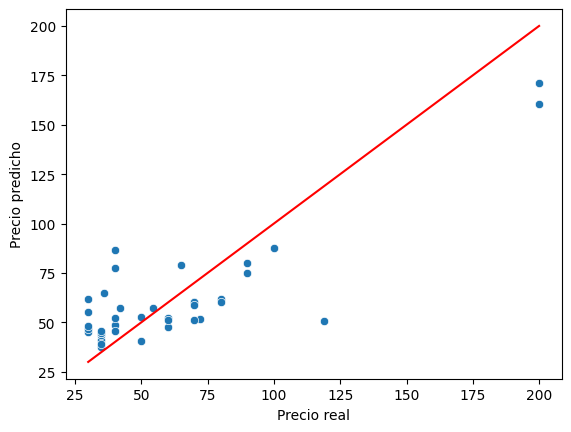

In [145]:
import seaborn as sns

sns.scatterplot(x=y_test, y=preds)
sns.lineplot(x=y_test, y=y_test, color="red")
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")

plt.show()